In [1]:
import uproot
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep

In [2]:
CONFIG_FILE = '/mnt/nvme0n1p4/CLion-Pycharm-projects/PycharmProjects/Onnx-Inference/CaloML/config_hgm_mc16.yaml'
ONNX_MODEL_PATH = '/mnt/nvme0n1p4/CLion-Pycharm-projects/PycharmProjects/Onnx-Inference/CaloML/HGM_3.model-03-12-2025.onnx'
INPUT_NTUPLE = '/mnt/nvme0n1p4/CLion-Pycharm-projects/PycharmProjects/Onnx-Inference/CaloML/ClusterEnergies.root'

In [3]:
df = uproot.concatenate(INPUT_NTUPLE, library='pd')

In [4]:
df.head()

,clusterE,clusterE_LCW,clusterE_Truth,clusterEta,cluster_SIGNIFICANCE,cluster_time,cluster_SECOND_TIME,cluster_CENTER_LAMBDA,cluster_CENTER_MAG,cluster_ENG_FRAC_EM,cluster_FIRST_ENG_DENS,cluster_LONGITUDINAL,cluster_LATERAL,cluster_PTD,cluster_ISOLATION,nPrimVtx,avgMu
0,16.499309,22.967885,16166.611328,1.874702,82.801994,0.102387,0.046077,256.037323,4177.289551,1.000000,0.020791,0.244089,0.399780,0.635285,0.880452,3,0.0
1,9.138374,13.189838,7197.510254,1.788090,20.072351,0.133287,0.781234,102.551758,4066.940918,0.846218,0.007591,0.798493,0.785001,0.244286,0.951204,3,0.0
2,2.748852,4.042329,2678.146729,0.399391,9.035995,1.206650,0.331080,1005.168762,2623.692383,0.058387,0.000053,0.739138,0.543075,0.555546,0.835458,3,0.0
3,3.375970,6.719827,2839.731201,1.105703,11.350155,0.203049,19.057089,312.104462,2783.903320,0.920799,0.000500,0.834718,0.816080,0.334258,0.746926,3,0.0
4,2.404664,4.596327,2574.151123,1.009612,8.215182,3.097960,30.369579,284.807587,2590.650879,1.000000,0.000565,0.812865,0.715392,0.345916,1.000000,3,0.0


In [5]:
from process_features import FeatureProcessor

In [6]:
processor = FeatureProcessor(config_path=CONFIG_FILE)
df_scaled = processor.transform(df)
model_outputs = processor.run_inference(model_path=ONNX_MODEL_PATH, df=df_scaled)

FeatureProcessor initialized successfully.

Applying transformations to 13565 rows...
  - Processing column 'clusterE'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'clusterEta'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_SIGNIFICANCE'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_time'...
    - Applied 'MaxAbsolute' successfully.
  - Processing column 'cluster_SECOND_TIME'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_CENTER_LAMBDA'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_CENTER_MAG'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_ENG_FRAC_EM'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_FIRST_ENG_DENS'...
    - Applied 'LogTenStandard' successfully.
  - Processing column 'cluster_LONGITUDINAL'...
    - Applied 'Standard' successfully.
  - Processing column 'cluster_LATERAL'...

/mnt/nvme0n1p4/CLion-Pycharm-projects/PycharmProjects/Onnx-Inference/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
import scipy
import torch
import numpy as np

import os
from scipy.optimize import fsolve
from scipy.stats import norm

def find_gmm_modes(alphas: np.ndarray, mus: np.ndarray, sigmas: np.ndarray, initial_guesses: np.ndarray = None) -> np.ndarray:
    """
    Finds all modes (local maxima) of a 1D Gaussian Mixture Model (GMM).

    The modes are found by locating the roots of the first derivative of the GMM's
    probability density function (PDF) using a numerical solver. Only roots that
    correspond to local maxima (i.e., where the second derivative is negative)
    are returned.

    Args:
        alphas (np.ndarray): Mixture weights for the GMM components. Shape (n_components,).
        mus (np.ndarray): Means for the GMM components. Shape (n_components,).
        sigmas (np.ndarray): Standard deviations for the GMM components. Shape (n_components,).
        initial_guesses (np.ndarray, optional): Initial points for the root-finding
            algorithm. If None, the component means (`mus`) are used as initial guesses.

    Returns:
        np.ndarray: A sorted array containing the x-values of the found modes.
    """
    # The first derivative of the GMM PDF. A mode exists where this is zero.
    def gmm_pdf_derivative(x: np.ndarray) -> np.ndarray:
        # The derivative of a gaussian N(x|m,s) is N(x|m,s) * -(x-m)/s^2
        # We sum this over all components, weighted by alpha.
        # Reshaping for broadcasting allows for efficient computation
        x_r = np.asarray(x).reshape(-1, 1) # (n_guesses, 1)
        a_r = alphas.reshape(1, -1) # (1, n_components)
        m_r = mus.reshape(1, -1)
        s_r = sigmas.reshape(1, -1)
        
        pdf_vals = norm.pdf(x_r, loc=m_r, scale=s_r)
        derivative_term = -(x_r - m_r) / (s_r**2)
        return np.sum(a_r * pdf_vals * derivative_term, axis=1)

    # The second derivative of the GMM PDF, used to verify a maximum.
    def gmm_pdf_second_derivative(x: np.ndarray) -> np.ndarray:
        # The second derivative of a gaussian N(x|m,s) is N(x|m,s) * ((x-m)^2/s^4 - 1/s^2)
        x_r = np.asarray(x).reshape(-1, 1)
        a_r = alphas.reshape(1, -1)
        m_r = mus.reshape(1, -1)
        s_r = sigmas.reshape(1, -1)

        pdf_vals = norm.pdf(x_r, loc=m_r, scale=s_r)
        second_derivative_term = ((x_r - m_r)**2 / (s_r**4)) - (1 / (s_r**2))
        return np.sum(a_r * pdf_vals * second_derivative_term, axis=1)

    if initial_guesses is None:
        # Component means are good starting points to find modes.
        # We can also add midpoints between means as guesses to find modes between components.
        sorted_mus = np.sort(mus)
        mid_points = (sorted_mus[:-1] + sorted_mus[1:]) / 2
        initial_guesses = np.concatenate([mus, mid_points])

    # Find roots of the first derivative using the initial guesses.
    found_roots, _, ier, _ = fsolve(gmm_pdf_derivative, initial_guesses, full_output=True)
    
    if ier != 1: # fsolve did not converge
        return np.array([])

    # Filter for unique roots (rounding is a simple way to group close roots)
    unique_roots = np.unique(np.round(found_roots, decimals=5))

    # A mode must be a maximum, so the second derivative must be negative.
    second_deriv_vals = gmm_pdf_second_derivative(unique_roots)
    modes = unique_roots[second_deriv_vals < 0]

    return np.sort(modes)

def log_likelihood(x, mus, log_sigma2s, alphas):
    """
    Logarithm of the probability density of a Gaussian mixture distribution (log-likelihood).
    This construction uses the log-sum-exp method from PyTorch which is numerically
    more stable then just computing: log(prob) = log(sum_i alpha_i*Gauss(mu_i, sigma_i))
    """

    # calculate one-dimensional negative log-Gaussians
    # neg_log_gauss = -log(Gauss(mu_i, sigma_i))
    # neg_log_gauss : shape = (num_monte, batch_size, x_sample, 3)
    neg_log_gauss  = np.pow(mus-x, 2.0)/(2.0*np.exp(log_sigma2s)) + 0.5*log_sigma2s
    neg_log_gauss += 0.5*np.log(2.0*np.pi) # constant

    # log_prob_components = -neg_log_gauss_i + log(alpha_i)
    #                     = log(Gauss(mu_i, sigma_i)) + log(alpha_i)
    # log_prob_components : shape = (num_monte, batch_size, x_sample, 3)
    log_likelihood_components = -neg_log_gauss + np.log(alphas)
    
    # log_prob = log(sum_i exp(log_prob_components_i))
    #          = log(sum_i exp(log(Gauss(mu_i, sigma_i)) + log(alpha_i)))
    # log_prob : shape = (num_monte, batch_size, x_sample)
    log_likelihood = scipy.special.logsumexp(log_likelihood_components, axis=-1)

    return log_likelihood


def modes(mus, sigma2s, alphas):
    # select range to check for maxima
    x_min = 0.9*np.min(mus, axis=-1)
    x_max = 1.1*np.max(mus, axis=-1)
    
    # create array of ranges to check for maxima
    x_test = np.linspace(x_min, x_max, num=1000)
    # x_test  : shape = (x_sample, batch_size)
    # mus     : shape = (batch_size, num_mixtures)
    # sigma2s : shape = (batch_size, num_mixtures)
    # alphas  : shape = (batch_size, num_mixtures)

    # reshape parameters for likelihood computations
    x_test_reshaped  = np.transpose(x_test,  axes=(1, 0))[:,:,None]
    mus_reshaped     = np.transpose(mus,     axes=(0, 1))[:,None,:]
    sigma2s_reshaped = np.transpose(sigma2s, axes=(0, 1))[:,None,:]
    alphas_reshaped  = np.transpose(alphas,  axes=(0, 1))[:,None,:]

    # compute negative log-likelihood (NLL)
    neg_log_likelihood = -log_likelihood(x_test_reshaped, mus_reshaped, np.log(sigma2s_reshaped), alphas_reshaped)

    # choose x-point with largest likelihood value (= smallest NLL value)
    idxs  = np.argmin(neg_log_likelihood, axis=-1, keepdims=True)
    modes = np.take_along_axis(np.squeeze(x_test_reshaped, axis=-1), idxs, axis=-1)

    # shape = (batch_size)
    predictions = np.squeeze(modes, axis=-1)

    return predictions


mus, log_sigma2s, alphas = model_outputs
mus_tst, sigmas_tst, alphas_tst = model_outputs
#sigma2s = np.exp(log_sigma2s)
#predictions = modes(10**mus, sigma2s, alphas)

#df['clusterE_ML'] = predictions
#df['clusterE_mu_0'] = 10**mus[:,0]
#df['clusterE_mu_1'] = 10**mus[:,1]
#df['clusterE_mu_2'] = 10**mus[:,2]


# In your notebook cell
# (assuming find_gmm_modes is defined in a previous cell)

print('[info] Starting peak (mode) finder loop')
#ntopo = mus_tst.shape[0]
ntopo = 13565
all_modes = []
n_modes = []

for t in range(ntopo):
    if (t % 1000 == 0): 
        print(f'[info] Scanning {t} topo-cluster')
    
    modes = find_gmm_modes(alphas_tst[t], mus_tst[t], sigmas_tst[t])
    
    all_modes.append(modes)
    n_modes.append(len(modes))

# ... (code to save results) ...


[info] Starting peak (mode) finder loop
[info] Scanning 0 topo-cluster
[info] Scanning 1000 topo-cluster
[info] Scanning 2000 topo-cluster
[info] Scanning 3000 topo-cluster
[info] Scanning 4000 topo-cluster
[info] Scanning 5000 topo-cluster
[info] Scanning 6000 topo-cluster
[info] Scanning 7000 topo-cluster
[info] Scanning 8000 topo-cluster
[info] Scanning 9000 topo-cluster
[info] Scanning 10000 topo-cluster
[info] Scanning 11000 topo-cluster
[info] Scanning 12000 topo-cluster
[info] Scanning 13000 topo-cluster


In [8]:
df.head(100)

,clusterE,clusterE_LCW,clusterE_Truth,clusterEta,cluster_SIGNIFICANCE,cluster_time,cluster_SECOND_TIME,cluster_CENTER_LAMBDA,cluster_CENTER_MAG,cluster_ENG_FRAC_EM,...,cluster_LONGITUDINAL,cluster_LATERAL,cluster_PTD,cluster_ISOLATION,nPrimVtx,avgMu,clusterE_ML,clusterE_mu_0,clusterE_mu_1,clusterE_mu_2
0,16.499309,22.967885,16166.611328,1.874702,82.801994,0.102387,0.046077,256.037323,4177.289551,1.000000,...,0.244089,0.399780,0.635285,0.880452,3,0.0,1.656580,2.816226,1.657825,4.535771
1,9.138374,13.189838,7197.510254,1.788090,20.072351,0.133287,0.781234,102.551758,4066.940918,0.846218,...,0.798493,0.785001,0.244286,0.951204,3,0.0,2.928990,6.030157,2.926821,8.770356
2,2.748852,4.042329,2678.146729,0.399391,9.035995,1.206650,0.331080,1005.168762,2623.692383,0.058387,...,0.739138,0.543075,0.555546,0.835458,3,0.0,13.468621,11.550235,5.622105,13.469419
3,3.375970,6.719827,2839.731201,1.105703,11.350155,0.203049,19.057089,312.104462,2783.903320,0.920799,...,0.834718,0.816080,0.334258,0.746926,3,0.0,1.538067,2.712783,1.538912,3.087977
4,2.404664,4.596327,2574.151123,1.009612,8.215182,3.097960,30.369579,284.807587,2590.650879,1.000000,...,0.812865,0.715392,0.345916,1.000000,3,0.0,1.293353,2.362661,1.293431,2.061866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.582060,7.581898,1604.418335,2.125524,4.507909,-0.036675,1.147723,186.965652,4037.414551,1.000000,...,0.644143,0.676934,0.316248,1.000000,3,0.0,1.044229,2.855145,1.045254,2.168230
96,1.045826,2.598900,1046.365601,1.176875,4.328332,-0.257185,2.676292,307.401154,2976.345703,1.000000,...,0.470703,0.498132,0.472642,1.000000,3,0.0,0.619684,1.251272,0.619307,0.671279
97,2.394577,6.370054,2386.060791,2.095114,7.389097,-0.209535,0.601054,296.960022,4154.207520,0.917677,...,0.843897,0.426383,0.422271,1.000000,3,0.0,1.552736,3.797566,1.552084,3.058410
98,3.000358,8.935231,2545.290283,2.401365,7.978319,-1.189161,1.980490,175.444214,3985.296387,1.000000,...,0.418355,0.166791,0.517298,1.000000,3,0.0,1.352838,4.154567,1.354054,3.503804


,clusterE,clusterE_LCW,clusterE_Truth,clusterEta,cluster_SIGNIFICANCE,cluster_time,cluster_SECOND_TIME,cluster_CENTER_LAMBDA,cluster_CENTER_MAG,cluster_ENG_FRAC_EM,...,cluster_LONGITUDINAL,cluster_LATERAL,cluster_PTD,cluster_ISOLATION,nPrimVtx,avgMu,clusterE_ML,clusterE_mu_0,clusterE_mu_1,clusterE_mu_2


In [11]:
mplhep.style.use('ATLAS')

(exptext: Custom Text(0.05, 0.95, 'ATLAS'),
 expsuffix: Custom Text(0.05, 0.955, 'Simulation Preliminary'),
 supptext: Custom Text(0.05, 0.95, ''),
 expsuffix: Custom Text(0.05, 0.95, '$\\sqrt{s} = \\mathrm{13\\ TeV}$'))

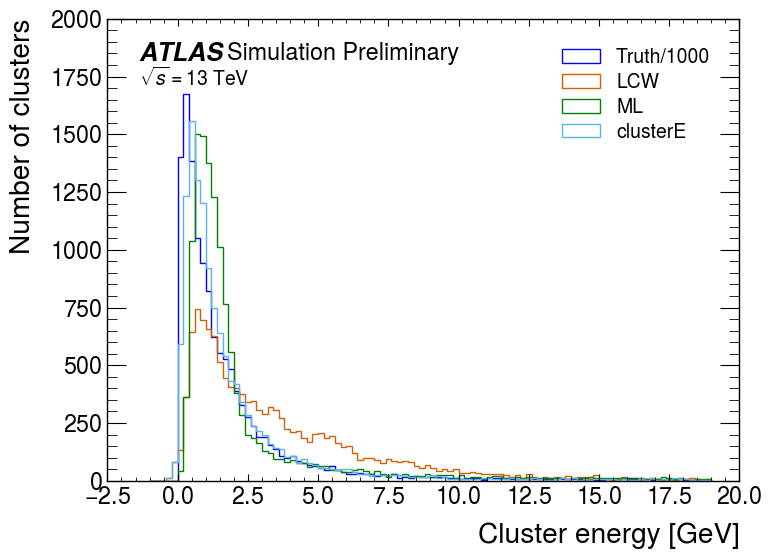

In [12]:
fig, ax = plt.subplots()
ax.hist(df['clusterE_Truth']/1000, range=(-1,19), bins=100, histtype='step', label='Truth/1000', color='b')
ax.hist(df['clusterE_LCW'], range=(-1,19), bins=100, histtype='step', label='LCW')
ax.hist(df['clusterE_ML'], range=(-1,19), bins=100, histtype='step', label='ML', color='g')
ax.hist(df['clusterE'], range=(-1,19), bins=100, histtype='step', label='clusterE')
ax.legend()
ax.set_ylim(0, 2000)
ax.set_xlabel('Cluster energy [GeV]')
ax.set_ylabel('Number of clusters')
mplhep.atlas.label('Preliminary', data=False, ax=ax)

In [13]:
mus = np.array([
    [5.0, 15.0, 10.0],
    [2.0, 8.0, 20.0]
])
sigma2s = np.array([
    [1.5, 1.0, 5.0],
    [2.0, 3.0, 0.5]
])
alphas = np.array([
    [0.45, 0.45, 0.1],
    [0.1, 0.2, 0.7]
])

In [14]:
modes(mus, sigma2s, alphas)

array([14.98648649, 19.9981982 ])

In [15]:
from model import modes as modes_pytorch
import torch

In [16]:
modes_pytorch(torch.from_numpy(mus), torch.from_numpy(sigma2s), torch.from_numpy(alphas))

tensor([14.9865, 19.9982], dtype=torch.float64)

In [17]:
! ./cpp/main

--- Test Case 1 ---
mus: {5.0, 15.0, 10.0}
sigma2s: {1.5, 1.0, 5.0}
alphas: {0.45, 0.45, 0.1}
Predicted mode: 14.9865

--- Test Case 2 ---
mus: {2.0, 8.0, 20.0}
sigma2s: {2.0, 3.0, 0.5}
alphas: {0.1, 0.2, 0.7}
Predicted Mode: 19.9982
